In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import pandas as pd

## Analysis of total cases

![](out/seihrd.png)

This is the idealised SEIR model with isolation (Hospitalisation) and Deaths. In the model below, we also want to capture the discharge information (H to R) so we capture them in a new compartment G (discharGe).

The data we have is:
- newly reported cases (entries into the I compartment)
- cumulative newly reported cases (square I box)
- number of people in isolation (H)
- cumulative number of people ever in isolation (square box H)
- number of discharged from isolation
- number of deaths

In [2]:
def seir(t, y, p):
    b, g, e, d, a, m = p[:6]
    S,E,I,H,G,R,D,cE,cH = y[:9]
    return [
        -b*S*I/(S+E+I+H+G+R),
        b*S*I/(S+E+I+H+G+R)-g*E,
        g*E-(e+a+m)*I,
        e*I-d*H,
        d*H,
        a*I,
        m*I,
        g*E,
        e*I
    ]

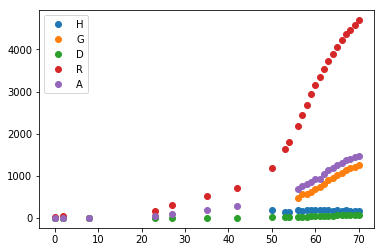

In [3]:
time = [0,2,8,23,27,35,42,50,53,54,56,57,58, 59,60,61,62,63, 64,65, 66,67,68,69,70]
S = [141105] + [None]*(len(time)-1)
R = [54874] + [None]*(len(time)-1)
H = [0, 0, 0, 11, None, None, None, 189, 147, 147, 183, 176, 193,  190, 197, 189, 191, 183,  174,177, 172,178,165,159,159]
G = [4, 7, 7, 37, None, None, None, None, None, None, 471, 558, 572,  620, 676, 727, 809, 893,  949,1009, 1076,1128,1177,1212,1248]
D = [0, 0, 1, 1, 3, 3, 6, 16, 20, 22, 25, 32, 33,  39, 42, 44, 48, 53,  55,60, 62,63,65,68,70]
cE = [28, 36, None, 169, 314, 513, 716, 1174, 1644, 1797, 2194, 2437, 2686,  2936, 3149, 3357, 3530, 3728,  3881,4052, 4217,4357,4460,4581,4693]
cH = [4, 7, 8, 49, 91, 195, 290, None, None, None, 679, 766, 798,  849, 915, 915, 1048, 1129,  1178,1246, 1310,1369,1407,1439,1477]

plt.plot(time, H, 'o', time, G, 'o', time, D, 'o', time, cE, 'o', time , cH, 'o')
plt.legend("HGDRA")

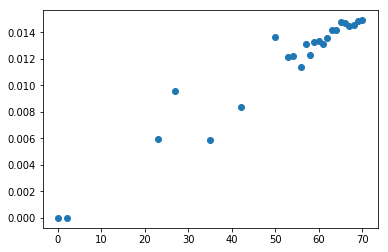

In [4]:
plt.plot(time,[d/ce if ce else None for d,ce in zip(D,cE)],'o')

In [5]:
data_pd = np.vstack([H, G, D, cE, cH]).astype(float).T
start = 2
data_time = time[start:]
data_pd = data_pd[start:,:]

p0 = [1.5, 1e-6, 0, 1e-6, 1e-6, 0.015]
config = {
    "grid_size": 63*2,
    "basis_number": 31,
    "model_form": {
        "state": 9,
        "parameters": 6
    },
    "time_span": [time[0], time[-1]*1.5],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(data_time)},
    "observation_vector": [3,4,6,7,8],
    "weightings":[
        [1]*9,
        [1]*len(data_time)
    ],
    "regularisation_value": copy(p0),
}

In [6]:
model = modeller.Model(config)
config['regularisation_value'][0] = model.ps[0]
config['regularisation_value'][2] = model.ps[2]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 10,
        
    }
}
solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [7]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [8]:
c0 = [2500*np.ones(config['basis_number']) for _ in range(9)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*9) + [0]*len(config['regularisation_value'])
alpha = 1e1

In [9]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4239
Number of nonzeros in Lagrangian Hessian.............:     7462

Total number of variables............................:      285
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

(0, 3000)

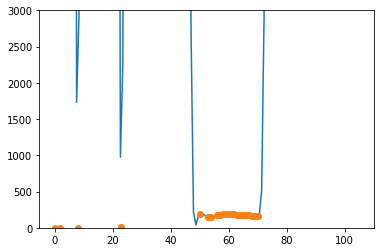

In [10]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[3])
plt.plot(time, H, 'o')
plt.ylim([0, 3000])

In [11]:
prange = np.logspace(-6, 6, num=100)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': 0,
        'ubg': 100000,
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-06
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4239
Number of nonzeros in Lagrangian Hessian.............:     7462

Total number of variables............................:      285
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1134
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1134
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du

 250 2.0599391e+002 0.00e+000 2.38e-004  -8.6 4.08e+001 -13.9 1.00e+000 1.00e+000h  1
 260 2.0599391e+002 0.00e+000 7.86e-004  -8.6 5.55e+003    -  1.00e+000 5.00e-001h  2
 270 2.0599391e+002 0.00e+000 5.89e-004  -8.6 8.20e+003    -  1.00e+000 5.00e-001h  2
 280 2.0599394e+002 0.00e+000 6.53e-002  -9.0 8.74e+001  -7.1 1.94e-001 4.72e-010h 27
 290 2.0599391e+002 0.00e+000 1.41e-006  -9.0 8.97e+001    -  5.47e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 2.0599391e+002 0.00e+000 3.25e-009  -9.0 1.82e-002  -9.0 1.00e+000 1.00e+000h  1

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:  2.0599390721401028e+002   2.0599390721401028e+002
Dual infeasibility......:  3.2475101446797916e-009   3.2475101446797916e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.0912000876057377e-010   9.09120008760573

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 2.0602671e+002 0.00e+000 2.65e-001  -8.6 4.87e+003 -14.5 1.00e+000 5.00e-001f  2
 110 2.0602656e+002 0.00e+000 2.68e-001  -8.6 1.95e+003 -13.9 1.00e+000 9.21e-002h  1
 120 2.0602640e+002 0.00e+000 2.92e-001  -8.6 7.63e+003 -14.2 2.69e-001 1.29e-001f  3
 130 2.0602618e+002 0.00e+000 1.56e-001  -8.6 1.39e+003 -13.5 4.28e-001 1.00e+000f  1
 140 2.0602597e+002 0.00e+000 2.00e-001  -8.6 7.68e+002 -13.3 1.00e+000 1.00e+000f  1
 150 2.0602569e+002 0.00e+000 6.13e-001  -8.6 2.83e+003 -13.5 5.02e-001 5.00e-001f  2
 160 2.0602542e+002 0.00e+000 1.38e-001  -8.6 3.14e+003 -13.8 7.66e-002 1.57e-001f  1
 170 2.0602518e+002 0.00e+000 1.91e-001  -8.6 6.12e+002 -13.2 1.00e+000 2.90e-001h  1
 180 2.0602493e+002 0.00e+000 2.78e-002  -8.6 1.76e+002 -10.7 1.00e+000 1.00e+000h  1
 190 2.0602461e+002 0.00e+000 1.16e-001  -8.6 9.79e+002 -13.7 1.00e+000 2.54e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  40 2.0605815e+002 0.00e+000 1.46e-001  -8.6 5.03e+002 -12.7 1.00e+000 1.00e+000f  1
  50 2.0605697e+002 0.00e+000 1.08e-001  -8.6 9.98e+002 -12.9 2.37e-003 5.29e-001f  1
  60 2.0605611e+002 0.00e+000 2.13e-001  -8.6 4.22e+002 -11.4 1.71e-002 1.56e-001f  1
  70 2.0605555e+002 0.00e+000 1.75e-001  -8.6 4.75e+002 -12.6 5.10e-001 1.00e+000f  1
  80 2.0605503e+002 0.00e+000 1.31e-001  -8.6 3.96e+002 -12.8 2.10e-001 3.32e-001f  1
  90 2.0605465e+002 0.00e+000 1.79e-001  -8.6 5.04e+002 -13.1 3.12e-001 9.53e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 2.0605445e+002 0.00e+000 2.14e-002  -8.6 5.78e+001  -9.7 1.00e+000 1.00e+000h  1
 110 2.0605432e+002 0.00e+000 3.40e-003  -8.6 9.77e+002 -13.6 6.89e-002 7.48e-001f  1
 120 2.0605391e+002 0.00e+000 4.02e-002  -8.6 3.70e+003 -13.8 9.20e-002 7.61e-001f  1
 130 2.0605372e+002 0.00e+000 1.28e-004  -8.6 1.51e+000  -7.6 1.00e+000 1.00e+000h  1
 140 2.0605366e+002 0.00e+000 6.59e-003  -8.6 2.21e+002 -12

  30 2.0609690e+002 0.00e+000 1.20e-001  -5.7 8.60e+002 -10.7 1.00e+000 1.00e+000f  1
  40 2.0609307e+002 0.00e+000 1.05e-001  -5.7 8.88e+001  -9.6 1.00e+000 1.00e+000f  1
  50 2.0609085e+002 0.00e+000 1.68e-001  -5.7 3.82e+002 -12.5 1.00e+000 1.00e+000f  1
  60 2.0608928e+002 0.00e+000 5.43e-002  -5.7 1.54e+002 -11.9 1.00e+000 1.00e+000f  1
  70 2.0608863e+002 0.00e+000 1.95e-002  -5.7 9.81e+002 -13.0 1.00e+000 1.00e+000f  1
  80 2.0608773e+002 0.00e+000 8.40e-004  -5.7 2.67e+002 -12.3 1.00e+000 1.00e+000f  1
  90 2.0608724e+002 0.00e+000 2.05e-002  -5.7 3.64e+002 -13.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 2.0608663e+002 0.00e+000 2.47e-003  -5.7 1.10e+002 -12.8 1.00e+000 1.00e+000h  1
 110 2.0608664e+002 0.00e+000 1.22e-005  -5.7 5.60e-001  -9.8 1.00e+000 1.00e+000h  1
 120 2.0608645e+002 0.00e+000 2.46e-004  -8.6 6.24e+001 -13.2 1.00e+000 1.00e+000h  1
 130 2.0608642e+002 0.00e+000 6.75e-005  -8.6 5.48e+000 -11

  30 2.0617504e+002 0.00e+000 2.59e-001  -5.7 3.43e+002  -9.2 9.36e-001 2.20e-001f  1
  40 2.0615381e+002 0.00e+000 9.15e-002  -5.7 4.29e+002 -11.3 1.00e+000 1.00e+000f  1
  50 2.0614976e+002 0.00e+000 1.39e+000  -5.7 4.41e+004 -12.5 9.97e-002 5.80e-002f  3
  60 2.0614528e+002 0.00e+000 3.05e-001  -5.7 3.77e+002 -11.8 1.00e+000 1.00e+000f  1
  70 2.0614245e+002 0.00e+000 6.68e-003  -5.7 4.37e+002 -12.0 2.63e-001 8.54e-001f  1
  80 2.0614092e+002 0.00e+000 1.74e-001  -5.7 1.09e+003 -12.2 1.00e+000 3.50e-001f  2
  90 2.0613868e+002 0.00e+000 5.08e-003  -5.7 3.23e+002 -12.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 2.0613770e+002 0.00e+000 2.50e-003  -5.7 4.21e+002 -12.6 1.00e+000 1.00e+000f  1
 110 2.0613760e+002 0.00e+000 1.09e-005  -8.6 4.92e+000  -8.2 1.00e+000 8.55e-001f  1
 120 2.0613758e+002 0.00e+000 4.04e-004  -8.6 2.12e+002 -13.0 1.00e+000 1.00e+000h  1
 130 2.0613751e+002 0.00e+000 1.54e-003  -8.6 9.66e+002 -13

 130 2.0626647e+002 0.00e+000 3.72e-001  -5.7 7.89e+002 -11.7 1.00e+000 1.00e+000f  1
 140 2.0625976e+002 0.00e+000 1.26e+000  -5.7 1.71e+003 -12.0 1.00e+000 1.00e+000f  1
 150 2.0625791e+002 0.00e+000 5.64e-001  -5.7 1.44e+003 -13.0 1.00e+000 1.00e+000f  1
 160 2.0625727e+002 0.00e+000 2.81e-002  -5.7 7.11e+002 -13.3 1.00e+000 1.00e+000f  1
 170 2.0625665e+002 0.00e+000 3.66e-001  -5.7 1.02e+003 -13.4 1.00e+000 1.00e+000f  1
 180 2.0625609e+002 0.00e+000 1.97e+000  -5.7 2.69e+004 -14.1 9.66e-002 1.56e-001f  3
 190 2.0625560e+002 0.00e+000 2.73e-001  -5.7 1.60e+003 -13.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 2.0625481e+002 0.00e+000 1.42e+000  -5.7 8.81e+002 -12.8 1.00e+000 1.00e+000f  1
 210 2.0625385e+002 0.00e+000 1.72e+000  -5.7 1.90e+003 -13.1 1.00e+000 5.00e-001f  2
 220 2.0625263e+002 0.00e+000 3.44e+000  -5.7 1.82e+003 -13.3 1.00e+000 1.00e+000f  1
 230 2.0625118e+002 0.00e+000 3.12e-001  -5.7 5.18e+002 -11

  10 2.1114554e+002 0.00e+000 2.71e+001  -1.0 2.17e+003    -  6.00e-001 1.00e+000f  1
  20 2.0691728e+002 0.00e+000 1.23e-004  -2.5 1.88e-001  -4.5 1.00e+000 1.00e+000f  1
  30 2.0652650e+002 0.00e+000 1.36e-001  -5.7 5.32e+002  -8.8 3.14e-001 2.65e-001f  1
  40 2.0641715e+002 0.00e+000 7.28e-001  -5.7 3.54e+002 -10.8 1.00e+000 1.00e+000f  1
  50 2.0640651e+002 0.00e+000 8.15e-001  -5.7 3.88e+002 -12.0 1.00e+000 1.00e+000f  1
  60 2.0640298e+002 0.00e+000 9.24e-001  -5.7 1.05e+003 -12.2 1.00e+000 1.00e+000f  1
  70 2.0639720e+002 0.00e+000 2.37e+000  -5.7 3.79e+002  -9.8 1.00e+000 5.00e-001f  2
  80 2.0638693e+002 0.00e+000 2.08e+000  -5.7 1.20e+003 -11.9 1.00e+000 4.53e-001f  2
  90 2.0637005e+002 0.00e+000 5.53e-002  -5.7 5.14e+002 -11.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 2.0635718e+002 0.00e+000 3.37e-001  -5.7 4.23e+002 -11.4 1.00e+000 5.76e-001f  1
 110 2.0634952e+002 0.00e+000 9.89e-002  -5.7 2.64e+002 -11

  90 2.0663782e+002 0.00e+000 4.36e+000  -5.7 1.44e+003 -11.6 1.00e+000 4.55e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 2.0661765e+002 0.00e+000 1.97e+000  -5.7 4.45e+002  -9.6 1.00e+000 1.00e+000f  1
 110 2.0659181e+002 0.00e+000 6.66e-001  -5.7 1.19e+004 -11.7 7.47e-002 3.00e-002f  1
 120 2.0657564e+002 0.00e+000 6.71e-001  -5.7 7.26e+002 -11.0 1.00e+000 8.06e-001f  1
 130 2.0656471e+002 0.00e+000 3.14e-001  -5.7 1.48e+003    -  1.03e-001 2.97e-001f  1
 140 2.0655109e+002 0.00e+000 2.33e+000  -5.7 2.67e+003    -  9.49e-002 4.77e-001f  1
 150 2.0654186e+002 0.00e+000 4.13e-002  -5.7 3.32e+002    -  1.00e+000 1.00e+000f  1
 160 2.0654152e+002 0.00e+000 5.35e-003  -8.6 2.45e+001    -  5.99e-001 6.71e-001f  1

Number of Iterations....: 165

                                   (scaled)                 (unscaled)
Objective...............:  2.0654151634380312e+002   2.0654151634380312e+002
Dual infeasibility......:  2.7690171530069714e-009 

  10 2.1451213e+002 0.00e+000 6.61e+001  -1.0 1.73e+003    -  4.45e-001 1.00e+000f  1
  20 2.2745471e+002 0.00e+000 8.39e+001  -1.0 2.33e+004    -  6.64e-001 2.00e-001f  1
  30 2.0818815e+002 0.00e+000 1.45e+001  -2.5 2.82e+003  -9.2 1.00e+000 1.00e+000f  1
  40 2.0794460e+002 0.00e+000 2.16e+002  -2.5 1.54e+004    -  1.00e+000 1.00e+000f  1
  50 2.0794983e+002 0.00e+000 2.12e+001  -2.5 1.95e+006 -12.7 4.84e-005 9.45e-004f  5
  60 2.0795577e+002 0.00e+000 3.68e+001  -2.5 2.92e+003    -  1.00e+000 1.00e+000f  1
  70 2.0761070e+002 0.00e+000 2.05e+001  -3.8 1.11e+004    -  9.14e-001 4.19e-001f  2
  80 2.0755982e+002 0.00e+000 3.33e+000  -3.8 3.50e+003    -  1.00e+000 1.00e+000f  1
  90 2.0755431e+002 0.00e+000 1.91e+000  -3.8 3.98e+004    -  5.86e-001 1.71e-002f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 2.0754570e+002 0.00e+000 6.85e-001  -3.8 7.72e+002 -11.9 1.00e+000 1.00e+000f  1
 110 2.0753064e+002 0.00e+000 9.41e+000  -3.8 1.52e+003 -11

 180 2.0746373e+002 0.00e+000 1.16e+000  -5.7 3.92e+002 -10.3 9.41e-001 1.00e+000f  1
 190 2.0745820e+002 0.00e+000 5.74e+000  -5.7 7.98e+002 -11.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 2.0745675e+002 0.00e+000 1.75e-001  -5.7 1.21e+002 -11.8 1.00e+000 1.00e+000f  1
 210 2.0745638e+002 0.00e+000 7.44e-002  -5.7 1.17e+004 -13.8 1.00e+000 2.50e-001f  3
 220 2.0745581e+002 0.00e+000 2.98e-002  -8.6 6.20e+002 -12.3 4.37e-001 8.20e-001f  1
 230 2.0745494e+002 0.00e+000 5.94e-004  -8.6 9.63e+000  -8.9 1.00e+000 1.00e+000h  1
 240 2.0745463e+002 0.00e+000 8.92e-004  -8.6 1.39e+001    -  2.56e-001 1.00e+000f  1

Number of Iterations....: 242

                                   (scaled)                 (unscaled)
Objective...............:  2.0745463287404843e+002   2.0745463287404843e+002
Dual infeasibility......:  8.5707566353665269e-012   8.5707566353665269e-012
Constraint violation....:  0.0000000000000000e+000   0.00000

  20 2.0948251e+002 0.00e+000 1.03e-001  -5.7 7.91e+001  -6.4 7.21e-001 1.00e+000f  1
  30 2.0861247e+002 0.00e+000 1.68e+001  -5.7 2.31e+003 -10.3 5.72e-001 2.62e-001f  1
  40 2.0847950e+002 0.00e+000 1.92e-001  -5.7 3.02e+002  -9.6 6.80e-001 1.00e+000f  1
  50 2.0840268e+002 0.00e+000 1.92e-001  -5.7 2.87e+002    -  9.84e-001 9.57e-001f  1
  60 2.0839200e+002 0.00e+000 1.15e-001  -5.7 8.70e+001 -11.1 1.00e+000 1.00e+000f  1
  70 2.0839186e+002 0.00e+000 2.70e-001  -8.6 4.72e+003    -  9.20e-001 2.01e-001f  2
  80 2.0839162e+002 0.00e+000 1.36e-008  -8.6 4.41e-002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 81

                                   (scaled)                 (unscaled)
Objective...............:  2.0839162474381959e+002   2.0839162474381959e+002
Dual infeasibility......:  8.3466601954562202e-009   8.3466601954562202e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.1634210648435555e-009   1.1634210648

 220 2.0992272e+002 0.00e+000 2.61e-002  -3.8 3.15e+002 -10.6 1.00e+000 1.00e+000f  1
 230 2.0990878e+002 0.00e+000 3.76e-001  -3.8 8.40e+002 -10.9 1.00e+000 1.00e+000f  1
 240 2.0989290e+002 0.00e+000 3.49e-002  -3.8 3.11e+002 -10.2 1.00e+000 1.00e+000f  1
 250 2.0987322e+002 0.00e+000 1.28e-002  -3.8 1.13e+002  -9.6 1.00e+000 1.00e+000f  1
 260 2.0983307e+002 0.00e+000 1.62e-002  -3.8 5.12e+001  -8.9 1.00e+000 1.00e+000f  1
 270 2.0978825e+002 0.00e+000 3.86e+000  -3.8 1.17e+003 -10.1 1.00e+000 1.00e+000f  1
 280 2.0966533e+002 0.00e+000 5.71e+000  -3.8 6.93e+002  -9.4 1.00e+000 1.00e+000f  1
 290 2.0943472e+002 0.00e+000 5.89e-001  -3.8 8.16e+001  -8.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 2.0932160e+002 0.00e+000 5.22e-001  -3.8 6.66e+001  -7.7 1.00e+000 1.00e+000f  1
 310 2.0929720e+002 0.00e+000 1.05e+000  -3.8 1.38e+004    -  1.00e+000 5.00e-001f  2
 320 2.0928872e+002 0.00e+000 8.32e+000  -5.7 1.14e+003    

Total number of variables............................:      285
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1134
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1134
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2.1068285e+002 0.00e+000 3.89e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
  10 2.2390475e+002 0.00e+000 2.72e+002  -1.0 2.22e+004    -  3.83e-002 3.73e-002f  2
  20 2.1175667e+002 0.00e+000 3.31e+001  -2.5 3.73e+004    -  2.44e-002 9.55e-003f  4
  30 2.1170233e+002 0.00e+000 3.10e+001  -2.5 1.53e+003  -9.2 1.00e+000 2.50e-001f  

  20 2.3148871e+002 0.00e+000 3.44e+002  -1.0 6.46e+002  -6.9 1.00e+000 1.00e+000f  1
  30 2.3131185e+002 0.00e+000 1.52e+001  -1.0 1.86e+002  -7.0 1.00e+000 1.00e+000f  1
  40 2.3402902e+002 0.00e+000 2.89e+003  -1.0 1.31e+004    -  1.00e+000 5.00e-001f  2
  50 2.3262492e+002 0.00e+000 4.99e+001  -1.0 5.86e+002  -8.2 1.00e+000 1.00e+000f  1
  60 2.3286414e+002 0.00e+000 1.38e+003  -1.0 2.05e+004 -10.1 4.98e-001 5.49e-002f  2
  70 2.3378485e+002 0.00e+000 1.57e+001  -1.0 2.03e+003    -  1.00e+000 1.00e+000f  1
  80 2.1769098e+002 0.00e+000 3.72e+001  -2.5 8.18e+002  -9.9 1.00e+000 1.00e+000f  1
  90 2.1739243e+002 0.00e+000 1.10e+002  -2.5 7.17e+003    -  1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 2.1728478e+002 0.00e+000 5.68e+001  -2.5 3.59e+003    -  1.00e+000 2.50e-001f  3
 110 2.1713853e+002 0.00e+000 5.71e+001  -2.5 1.96e+003 -11.5 1.00e+000 1.00e+000f  1
 120 2.1691853e+002 0.00e+000 6.57e+001  -2.5 2.10e+003 -10

 200 2.1561483e+002 0.00e+000 1.60e-002  -3.8 4.16e+002 -10.5 1.00e+000 1.00e+000f  1
 210 2.1557151e+002 0.00e+000 9.00e-002  -5.7 2.04e+002  -9.9 7.52e-001 8.31e-001f  1
 220 2.1549900e+002 0.00e+000 4.80e-001  -5.7 9.90e+001  -9.3 1.00e+000 1.00e+000f  1
 230 2.1541567e+002 0.00e+000 7.18e-002  -5.7 3.13e+002  -9.5 1.00e+000 1.00e+000f  1
 240 2.1519643e+002 0.00e+000 2.51e+000  -5.7 3.85e+001  -7.1 1.00e+000 1.00e+000f  1
 250 2.1499949e+002 0.00e+000 2.86e-002  -5.7 1.09e+002  -8.2 1.00e+000 1.00e+000f  1
 260 2.1472930e+002 0.00e+000 4.90e-002  -5.7 5.02e+001  -7.6 3.10e-001 1.00e+000f  1
 270 2.1437472e+002 0.00e+000 1.28e+001  -5.7 4.12e+002  -8.7 5.86e-001 5.00e-001f  2
 280 2.1414939e+002 0.00e+000 5.97e-002  -5.7 5.72e+001  -7.6 1.00e+000 1.00e+000f  1
 290 2.1411346e+002 0.00e+000 5.42e-001  -5.7 7.75e+001 -11.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 2.1411160e+002 0.00e+000 1.38e-007  -5.7 1.74e+001    

 510 2.1603470e+002 0.00e+000 6.00e+001  -5.7 2.43e+005    -  3.89e-002 2.07e-002f  4
 520 2.1595622e+002 0.00e+000 4.68e+001  -5.7 9.30e+003    -  1.00e+000 5.00e-001f  2
 530 2.1594543e+002 0.00e+000 2.69e-004  -8.6 1.10e+001    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 533

                                   (scaled)                 (unscaled)
Objective...............:  2.1594542488302824e+002   2.1594542488302824e+002
Dual infeasibility......:  6.1587292591743657e-009   6.1587292591743657e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  3.2353853688695967e-009   3.2353853688695967e-009
Overall NLP error.......:  6.1587292591743657e-009   6.1587292591743657e-009


Number of objective function evaluations             = 950
Number of objective gradient evaluations             = 534
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 950
Number of equality

  70 2.4979217e+002 0.00e+000 1.68e+003  -1.0 6.32e+003    -  1.00e+000 1.25e-001f  4
  80 2.5124843e+002 0.00e+000 2.88e+003  -1.0 2.56e+003    -  1.00e+000 1.00e+000f  1
  90 2.5098009e+002 0.00e+000 1.07e+003  -1.0 4.93e+003    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 2.5100069e+002 0.00e+000 1.60e-002  -1.0 9.80e+000    -  1.00e+000 1.00e+000h  1
 110 2.3579639e+002 0.00e+000 2.44e+002  -2.5 1.84e+004 -10.5 5.36e-001 1.25e-001f  4
 120 2.3530622e+002 0.00e+000 6.54e+001  -2.5 5.46e+002  -9.8 1.00e+000 1.00e+000f  1
 130 2.3466682e+002 0.00e+000 3.59e+002  -2.5 3.83e+004 -11.0 3.90e-001 2.15e-002f  5
 140 2.3318693e+002 0.00e+000 1.83e+003  -2.5 3.25e+003 -10.3 1.00e+000 1.00e+000f  1
 150 2.2899682e+002 0.00e+000 1.59e+001  -2.5 4.33e+002  -8.3 1.00e+000 1.00e+000f  1
 160 2.2846056e+002 0.00e+000 1.16e+002  -2.5 2.38e+003 -10.3 1.00e+000 3.41e-001f  2
 170 2.2842029e+002 0.00e+000 1.75e+001  -2.5 9.46e+001  -7

 210 2.3123750e+002 0.00e+000 6.69e+001  -2.5 1.14e+003  -7.9 1.00e+000 2.50e-001f  3
 220 2.2910184e+002 0.00e+000 5.66e+001  -2.5 7.98e+004    -  5.40e-001 8.48e-002f  3
 230 2.2777788e+002 0.00e+000 3.52e+001  -2.5 3.77e+002  -7.8 1.00e+000 5.00e-001f  2
 240 2.2731132e+002 0.00e+000 1.29e-001  -2.5 2.26e+001  -8.0 1.00e+000 1.00e+000f  1
 250 2.2718249e+002 0.00e+000 4.35e-001  -2.5 7.29e+002    -  1.00e+000 1.00e+000f  1
 260 2.2700904e+002 0.00e+000 2.51e-001  -2.5 1.32e+003    -  1.00e+000 1.00e+000f  1
 270 2.2632589e+002 0.00e+000 1.12e+001  -3.8 6.01e+003 -10.9 1.00e+000 1.00e+000f  1
 280 2.2579997e+002 0.00e+000 6.15e+000  -3.8 9.93e+002 -10.2 1.00e+000 5.00e-001f  2
 290 2.2561857e+002 0.00e+000 1.72e+000  -3.8 5.69e+004    -  2.76e-001 4.93e-002f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 2.2552895e+002 0.00e+000 6.99e+000  -3.8 3.26e+002  -8.8 1.00e+000 5.00e-001f  2
 310 2.2518662e+002 0.00e+000 5.87e+000  -3.8 2.22e+002  -7

  30 2.6532069e+002 0.00e+000 3.46e+003  -1.0 6.46e+003    -  9.21e-001 1.00e+000f  1
  40 2.6769742e+002 0.00e+000 7.37e+003  -1.0 1.95e+004    -  8.04e-001 2.50e-001f  3
  50 2.6607749e+002 0.00e+000 1.46e+002  -1.0 1.88e+004    -  1.00e+000 2.50e-001f  3
  60 2.6655929e+002 0.00e+000 1.95e+003  -1.0 1.73e+003    -  1.00e+000 1.00e+000f  1
  70 2.6761104e+002 0.00e+000 3.72e+001  -1.0 4.69e+002    -  1.00e+000 1.00e+000f  1
  80 2.6901194e+002 0.00e+000 1.14e+002  -1.0 3.45e+002    -  1.00e+000 5.00e-001f  2
  90 2.5378419e+002 0.00e+000 2.16e+003  -2.5 5.82e+003  -8.0 3.30e-002 1.03e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 2.5123818e+002 0.00e+000 9.07e+002  -2.5 1.99e+003 -10.0 1.00e+000 5.00e-001f  2
 110 2.5067731e+002 0.00e+000 7.57e+000  -2.5 6.90e+002  -9.8 1.00e+000 1.00e+000f  1
 120 2.4998481e+002 0.00e+000 7.90e+001  -2.5 4.03e+002  -9.6 1.00e+000 1.00e+000f  1
 130 2.4933915e+002 0.00e+000 1.67e+003  -2.5 1.90e+003  -9


Number of Iterations....: 316

                                   (scaled)                 (unscaled)
Objective...............:  2.4158787089442762e+002   2.4158787089442762e+002
Dual infeasibility......:  1.7797830015363858e-010   1.7797830015363858e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5532072134788684e-009   2.5532072134788684e-009
Overall NLP error.......:  2.5532072134788684e-009   2.5532072134788684e-009


Number of objective function evaluations             = 531
Number of objective gradient evaluations             = 317
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 531
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 317
Number of Lagrangian Hessian evaluations             = 316
Total CPU secs in IPOPT (w/o function evaluations)   =      2.297
Total CPU secs in NLP function eval

  20 2.8813090e+002 0.00e+000 4.32e+003  -1.0 1.01e+003  -7.3 1.00e+000 1.00e+000f  1
  30 2.9020616e+002 0.00e+000 1.20e+003  -1.0 1.21e+004    -  4.01e-001 8.61e-002f  4
  40 2.9505534e+002 0.00e+000 3.53e+003  -1.0 1.73e+004    -  9.15e-001 2.32e-001f  2
  50 3.0006150e+002 0.00e+000 8.36e+003  -1.0 2.73e+004    -  6.14e-001 1.05e-001f  3
  60 3.0585042e+002 0.00e+000 4.33e+002  -1.0 2.09e+004    -  5.71e-001 2.50e-001f  3
  70 3.0515684e+002 0.00e+000 9.83e+002  -1.0 3.33e+002  -7.6 1.00e+000 1.00e+000f  1
  80 3.0600955e+002 0.00e+000 2.56e+003  -1.0 6.20e+003    -  1.00e+000 5.00e-001f  2
  90 3.0736675e+002 0.00e+000 6.43e+002  -1.0 8.51e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 3.0827297e+002 0.00e+000 3.12e+002  -1.0 5.97e+002    -  1.00e+000 5.00e-001f  2
 110 2.9595841e+002 0.00e+000 3.25e+003  -2.5 4.04e+003 -10.1 1.00e+000 1.00e+000f  1
 120 2.9439795e+002 0.00e+000 6.01e+002  -2.5 5.37e+002  -9

 290 2.7914235e+002 0.00e+000 1.50e+002  -3.8 3.51e+002  -8.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 2.7861525e+002 0.00e+000 2.33e-003  -3.8 1.47e+000  -5.7 1.00e+000 1.00e+000f  1
 310 2.7823237e+002 0.00e+000 4.60e+001  -5.7 1.66e+002  -7.8 1.00e+000 1.00e+000f  1
 320 2.7748069e+002 0.00e+000 4.33e-001  -5.7 5.63e+000  -6.2 1.00e+000 1.00e+000f  1
 330 2.7680732e+002 0.00e+000 2.49e+002  -5.7 7.12e+002  -8.3 1.00e+000 4.48e-001f  1
 340 2.7613464e+002 0.00e+000 1.03e+000  -5.7 2.42e+001  -6.7 1.00e+000 1.00e+000f  1
 350 2.7519939e+002 0.00e+000 3.12e+002  -5.7 3.74e+002  -7.9 1.00e+000 1.00e+000f  1
 360 2.7394194e+002 0.00e+000 1.18e+003  -5.7 7.52e+002  -8.1 1.00e+000 1.00e+000f  1
 370 2.7241274e+002 0.00e+000 1.13e-001  -5.7 3.26e+001  -6.6 7.84e-001 1.00e+000f  1
 380 2.7086684e+002 0.00e+000 1.67e-001  -5.7 4.67e+000  -5.0 3.08e-001 1.00e+000f  1
 390 2.6993443e+002 0.00e+000 1.00e+002  -5.7 7.19e+003    

  50 2.9580757e+002 0.00e+000 4.42e+001  -2.5 1.14e+002  -7.7 1.00e+000 1.00e+000f  1
  60 2.9501373e+002 0.00e+000 6.92e+001  -2.5 1.39e+002  -7.9 1.00e+000 1.00e+000f  1
  70 2.9439149e+002 0.00e+000 1.32e-001  -2.5 1.98e+000  -5.3 1.00e+000 1.00e+000f  1
  80 2.9420726e+002 0.00e+000 2.18e+000  -2.5 1.79e+003    -  1.00e+000 1.00e+000f  1
  90 2.9403229e+002 0.00e+000 3.98e-003  -5.7 3.53e+000  -8.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 99

                                   (scaled)                 (unscaled)
Objective...............:  2.9403134901074998e+002   2.9403134901074998e+002
Dual infeasibility......:  2.2815201642564742e-009   2.2815201642564742e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.1647764176494768e-009   2.1647764176494768e-009
Overall NLP error.......:  2.2815201642564742e-009   2.2815201642564742e-009




  60 3.4290060e+002 0.00e+000 9.74e-002  -5.7 2.34e+001  -9.1 1.00e+000 1.00e+000f  1
  70 3.4289829e+002 0.00e+000 1.20e-008  -8.6 2.27e-002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 71

                                   (scaled)                 (unscaled)
Objective...............:  3.4289828639186885e+002   3.4289828639186885e+002
Dual infeasibility......:  3.8437608639156646e-010   3.8437608639156646e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.8831831370876382e-010   9.8831831370876382e-010
Overall NLP error.......:  9.8831831370876382e-010   9.8831831370876382e-010


Number of objective function evaluations             = 136
Number of objective gradient evaluations             = 72
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 136
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluati

  10 4.5004165e+002 0.00e+000 3.10e+001  -2.5 1.10e+003    -  5.85e-001 1.00e+000f  1
  20 4.4990836e+002 0.00e+000 2.65e-002  -2.5 2.59e-001  -4.4 1.00e+000 1.00e+000f  1
  30 4.4976936e+002 0.00e+000 5.87e-007  -8.6 8.82e-002    -  1.00e+000 9.94e-001f  1

Number of Iterations....: 31

                                   (scaled)                 (unscaled)
Objective...............:  4.4976936089660063e+002   4.4976936089660063e+002
Dual infeasibility......:  2.0544868491788266e-010   2.0544868491788266e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  3.3931883144818156e-009   3.3931883144818156e-009
Overall NLP error.......:  3.3931883144818156e-009   3.3931883144818156e-009


Number of objective function evaluations             = 43
Number of objective gradient evaluations             = 32
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 43
Number of equality con

  30 5.9081243e+002 0.00e+000 3.86e-006  -5.7 1.74e+001    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 33

                                   (scaled)                 (unscaled)
Objective...............:  5.9081237688320846e+002   5.9081237688320846e+002
Dual infeasibility......:  1.1857894519791700e-011   1.1857894519791700e-011
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5564637297136176e-009   2.5564637297136176e-009
Overall NLP error.......:  2.5564637297136176e-009   2.5564637297136176e-009


Number of objective function evaluations             = 39
Number of objective gradient evaluations             = 34
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 39
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 34
Number of Lagrangian Hessian evaluations             = 33
Total CPU secs in IPO

  10 8.1338350e+002 0.00e+000 6.21e+000  -1.7 1.25e+003    -  6.75e-001 1.00e+000f  1
  20 8.1233037e+002 0.00e+000 5.95e+000  -3.8 1.10e+004    -  1.00e+000 5.00e-001f  2
  30 8.1230475e+002 0.00e+000 2.77e-005  -8.6 5.24e+001    -  1.00e+000 7.27e-001f  1

Number of Iterations....: 32

                                   (scaled)                 (unscaled)
Objective...............:  8.1230475187092918e+002   8.1230475187092918e+002
Dual infeasibility......:  7.1472349547275124e-010   7.1472349547275124e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.8107321403411044e-009   2.8107321403411044e-009
Overall NLP error.......:  2.8107321403411044e-009   2.8107321403411044e-009


Number of objective function evaluations             = 46
Number of objective gradient evaluations             = 33
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 46
Number of equality con

  30 1.2407449e+003 0.00e+000 1.13e-002  -5.7 7.54e+001    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 35

                                   (scaled)                 (unscaled)
Objective...............:  1.2407448055207842e+003   1.2407448055207842e+003
Dual infeasibility......:  2.5026654077730172e-010   2.5026654077730172e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5658944704496132e-009   2.5658944704496132e-009
Overall NLP error.......:  2.5658944704496132e-009   2.5658944704496132e-009


Number of objective function evaluations             = 40
Number of objective gradient evaluations             = 36
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 40
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 36
Number of Lagrangian Hessian evaluations             = 35
Total CPU secs in IPO

  10 1.7518676e+003 0.00e+000 1.99e+002  -1.7 7.24e+002    -  4.74e-001 1.00e+000f  1
  20 1.7492993e+003 0.00e+000 3.60e+000  -5.7 8.99e+003    -  9.14e-001 8.22e-001f  1

Number of Iterations....: 28

                                   (scaled)                 (unscaled)
Objective...............:  1.7492946107040927e+003   1.7492946107040927e+003
Dual infeasibility......:  2.8732286861258667e-010   2.8732286861258667e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.7748013839727886e-010   9.7748013839727886e-010
Overall NLP error.......:  9.7748013839727886e-010   9.7748013839727886e-010


Number of objective function evaluations             = 33
Number of objective gradient evaluations             = 29
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 33
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluation

  70 2.1226380e+003 0.00e+000 3.99e+000  -8.6 2.41e+003 -10.5 1.00e+000 2.50e-001f  3
  80 2.1226104e+003 0.00e+000 3.25e+001  -8.6 1.85e+003 -10.7 1.00e+000 1.00e+000f  1
  90 2.1225583e+003 0.00e+000 1.00e+001  -8.6 3.68e+001  -8.3 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 2.1225185e+003 0.00e+000 8.38e+000  -8.6 1.56e+002  -9.4 1.00e+000 1.00e+000f  1
 110 2.1224645e+003 0.00e+000 1.82e-004  -8.6 2.57e-002  -4.1 1.00e+000 1.00e+000h  1
 120 2.1224629e+003 0.00e+000 7.76e-002  -8.6 6.92e+001  -8.8 1.00e+000 1.00e+000f  1
 130 2.1223727e+003 0.00e+000 3.98e+000  -8.6 4.67e+001  -8.2 1.00e+000 1.00e+000f  1

Number of Iterations....: 137

                                   (scaled)                 (unscaled)
Objective...............:  2.1223630076012614e+003   2.1223630076012614e+003
Dual infeasibility......:  1.2359587366037438e-010   1.2359587366037438e-010
Constraint violation....:  0.0000000000000000e+000   0.00000

  10 2.4787362e+003 0.00e+000 5.85e+002  -1.0 1.23e+003    -  4.03e-001 1.25e-001f  4
  20 2.4720933e+003 0.00e+000 1.71e+000  -2.5 1.86e-001  -2.1 1.00e+000 1.00e+000f  1
  30 2.4718999e+003 0.00e+000 1.81e-002  -3.8 1.58e-001  -2.2 1.00e+000 8.99e-001f  1
  40 2.4718808e+003 0.00e+000 1.07e-002  -5.7 3.17e+000  -7.0 1.00e+000 7.76e-001f  1
  50 2.4716771e+003 0.00e+000 7.11e+000  -5.7 3.06e+001    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 58

                                   (scaled)                 (unscaled)
Objective...............:  2.4716769099375797e+003   2.4716769099375797e+003
Dual infeasibility......:  1.7112278784182317e-010   1.7112278784182317e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6080012404449754e-009   2.6080012404449754e-009
Overall NLP error.......:  2.6080012404449754e-009   2.6080012404449754e-009


Number of objective function evaluations             = 74
Number of objective gra

  20 2.8127086e+003 0.00e+000 4.32e+001  -3.8 2.25e+002    -  9.75e-001 9.32e-001f  1
  30 2.8123964e+003 0.00e+000 1.40e-001  -5.7 6.98e+001    -  1.00e+000 5.81e-001f  1

Number of Iterations....: 38

                                   (scaled)                 (unscaled)
Objective...............:  2.8123945331088366e+003   2.8123945331088366e+003
Dual infeasibility......:  7.6852701019472157e-010   7.6852701019472157e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  3.6871758368255498e-009   3.6871758368255498e-009
Overall NLP error.......:  3.6871758368255498e-009   3.6871758368255498e-009


Number of objective function evaluations             = 51
Number of objective gradient evaluations             = 39
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 51
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluation

  20 3.1800131e+003 0.00e+000 4.41e+002  -1.7 1.93e+003    -  8.24e-001 1.00e+000f  1
  30 3.1786854e+003 0.00e+000 5.17e+000  -3.8 1.26e-001  -1.2 5.75e-001 3.98e-001f  1
  40 3.1786206e+003 0.00e+000 1.51e-004  -3.8 4.28e-001  -6.0 1.00e+000 1.00e+000h  1
  50 3.1784205e+003 0.00e+000 5.68e+001  -5.7 4.75e+002  -8.9 1.00e+000 1.00e+000f  1
  60 3.1783523e+003 0.00e+000 7.63e-004  -8.6 6.12e-003    -  1.00e+000 8.84e-001f  1

Number of Iterations....: 61

                                   (scaled)                 (unscaled)
Objective...............:  3.1783522900982512e+003   3.1783522900982512e+003
Dual infeasibility......:  3.9299971977533115e-009   3.9299971977533115e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.7560631970179939e-009   2.7560631970179939e-009
Overall NLP error.......:  3.9299971977533115e-009   3.9299971977533115e-009


Number of objective function evaluations             = 87
Number of objective gra

  50 3.6147713e+003 0.00e+000 1.14e-002  -8.6 1.55e-001    -  9.06e-001 7.40e-001h  1

Number of Iterations....: 54

                                   (scaled)                 (unscaled)
Objective...............:  3.6147712629984599e+003   3.6147712629984599e+003
Dual infeasibility......:  1.9471826934725448e-009   1.9471826934725448e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5077118329420051e-009   2.5077118329420051e-009
Overall NLP error.......:  2.5077118329420051e-009   2.5077118329420051e-009


Number of objective function evaluations             = 75
Number of objective gradient evaluations             = 55
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 75
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 55
Number of Lagrangian Hessian evaluations             = 54
Total CPU secs in IPO

  20 4.1738757e+003 0.00e+000 1.01e+002  -3.8 8.50e+002    -  1.00e+000 8.04e-001f  1
  30 4.1737965e+003 0.00e+000 1.55e-001  -5.7 9.84e+000    -  9.23e-001 6.09e-001f  1

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:  4.1737963607471320e+003   4.1737963607471320e+003
Dual infeasibility......:  4.5125496268150357e-009   4.5125496268150357e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.7384417033812484e-009   2.7384417033812484e-009
Overall NLP error.......:  4.5125496268150357e-009   4.5125496268150357e-009


Number of objective function evaluations             = 42
Number of objective gradient evaluations             = 38
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 42
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluation

  10 4.9096359e+003 0.00e+000 6.80e-001  -1.7 9.16e-003   0.6 1.00e+000 1.00e+000f  1
  20 4.9071975e+003 0.00e+000 4.54e-001  -3.8 2.27e+001    -  6.85e-001 1.00e+000f  1

Number of Iterations....: 29

                                   (scaled)                 (unscaled)
Objective...............:  4.9071933358313108e+003   4.9071933358313108e+003
Dual infeasibility......:  8.2426195652266415e-009   8.2426195652266415e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059037707494288e-009   2.5059037707494288e-009
Overall NLP error.......:  8.2426195652266415e-009   8.2426195652266415e-009


Number of objective function evaluations             = 41
Number of objective gradient evaluations             = 30
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 41
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluation

  30 5.8291020e+003 0.00e+000 1.30e-001  -3.8 5.35e-003  -0.3 1.00e+000 6.02e-001f  1
  40 5.8290988e+003 0.00e+000 3.22e-004  -5.7 4.22e-002  -5.1 1.00e+000 1.00e+000h  1
  50 5.8290320e+003 0.00e+000 6.28e+001  -5.7 7.53e+000  -7.1 1.00e+000 1.00e+000f  1
  60 5.8289882e+003 0.00e+000 1.27e-003  -5.7 1.87e-002  -4.7 1.00e+000 1.00e+000h  1
  70 5.8289093e+003 0.00e+000 3.13e+002  -5.7 1.10e+003  -9.5 1.00e+000 8.19e-001f  1
  80 5.8289042e+003 0.00e+000 1.83e-007  -9.0 4.45e-009    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 89

                                   (scaled)                 (unscaled)
Objective...............:  5.8289042029209322e+003   5.8289042029209322e+003
Dual infeasibility......:  7.4060195183310723e-008   7.4060195183310723e-008
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.0909090909858958e-010   9.0909090909858958e-010
Overall NLP error.......:  7.4060195183310723e-008   7.4060195183310723e-0

 170 6.5063237e+003 0.00e+000 3.99e+000  -8.6 2.66e+001  -8.0 1.00e+000 1.00e+000f  1
 180 6.5062770e+003 0.00e+000 2.52e-003  -8.6 3.21e-004  -2.4 1.00e+000 1.00e+000h  1
 190 6.5062767e+003 0.00e+000 2.03e-002  -8.6 4.62e+000  -7.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 6.5062469e+003 0.00e+000 7.47e+000  -8.6 8.46e+000    -  1.00e+000 1.00e+000f  1
 210 6.5062469e+003 0.00e+000 7.96e-008  -8.6 5.38e-008    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 217

                                   (scaled)                 (unscaled)
Objective...............:  6.5062468924045406e+003   6.5062468924045406e+003
Dual infeasibility......:  2.8731000369506564e-008   2.8731000369506564e-008
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059035596800568e-009   2.5059035596800568e-009
Overall NLP error.......:  2.8731000369506564e-008   2.8731000369506564e-008



  60 7.1822223e+003 0.00e+000 7.97e+001  -1.7 3.26e-001  -2.7 1.00e+000 1.00e+000f  1
  70 7.1813026e+003 0.00e+000 1.65e+003  -1.7 5.09e+003    -  8.04e-001 1.56e-002f  7
  80 7.1806395e+003 0.00e+000 5.48e+000  -1.7 5.64e-003  -2.1 1.00e+000 1.00e+000f  1
  90 7.1797904e+003 0.00e+000 5.82e-001  -1.7 2.89e-001  -4.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 7.1791242e+003 0.00e+000 5.21e+002  -1.7 1.24e+001  -5.9 1.00e+000 5.00e-001f  2
 110 7.1782336e+003 0.00e+000 2.13e+000  -2.5 2.20e-001  -2.0 1.00e+000 1.00e+000f  1
 120 7.1777240e+003 0.00e+000 6.54e+000  -2.5 5.54e-001  -4.9 1.00e+000 1.00e+000f  1
 130 7.1774001e+003 0.00e+000 1.81e+003  -2.5 5.14e+001  -6.8 1.00e+000 5.00e-001f  2
 140 7.1771281e+003 0.00e+000 3.96e+000  -3.8 3.99e-002  -1.6 1.00e+000 6.26e-001f  1
 150 7.1768964e+003 0.00e+000 6.66e+002  -3.8 5.57e+003    -  1.00e+000 1.98e-002f  5
 160 7.1767035e+003 0.00e+000 1.25e+003  -3.8 2.68e+003    

 360 7.5296120e+003 0.00e+000 2.47e-001  -3.8 3.03e-001  -7.5 1.00e+000 1.00e+000h  1
 370 7.5296125e+003 0.00e+000 1.50e+000  -3.8 5.85e-003  -5.5 1.00e+000 1.00e+000h  1
 380 7.5296121e+003 0.00e+000 4.64e-003  -5.7 1.41e-003  -3.4 1.00e+000 1.00e+000h  1
 390 7.5296120e+003 0.00e+000 1.49e-002  -8.6 1.23e+000  -8.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400 7.5296117e+003 0.00e+000 1.49e+001  -8.6 1.77e+001  -9.3 1.00e+000 1.00e+000f  1
 410 7.5296114e+003 0.00e+000 9.90e+000  -8.6 6.36e-001  -7.8 1.00e+000 1.00e+000h  1
 420 7.5296110e+003 0.00e+000 1.50e+001  -8.6 6.19e+001  -9.8 1.00e+000 1.00e+000f  1
 430 7.5296107e+003 0.00e+000 9.68e+001  -8.6 1.15e+002 -10.1 1.00e+000 1.00e+000f  1
 440 7.5296104e+003 0.00e+000 3.29e-002  -8.6 4.11e-001  -7.6 1.00e+000 1.00e+000h  1
 450 7.5296101e+003 0.00e+000 2.41e+000  -8.6 4.83e+001  -9.7 1.00e+000 1.00e+000f  1
 460 7.5296096e+003 0.00e+000 3.44e+000  -8.6 3.09e-001  -7

 300 7.9346284e+003 0.00e+000 2.40e-003  -5.7 1.60e-004  -1.9 1.00e+000 1.00e+000f  1
 310 7.9346193e+003 0.00e+000 2.07e-004  -5.7 6.84e-005  -1.6 1.00e+000 1.00e+000f  1
 320 7.9346062e+003 0.00e+000 9.19e-004  -5.7 4.52e-005  -1.3 1.00e+000 1.00e+000f  1
 330 7.9345964e+003 0.00e+000 1.99e-003  -5.7 9.12e-005  -0.9 1.00e+000 1.00e+000f  1
 340 7.9345842e+003 0.00e+000 4.21e-001  -8.6 1.27e-003  -1.5 1.00e+000 1.00e+000f  1
 350 7.9345789e+003 0.00e+000 1.13e-006  -8.6 4.16e-008    -  1.00e+000 1.00e+000F  1
 360 7.9345789e+003 0.00e+000 1.81e-007  -8.6 3.30e-008    -  1.00e+000 1.00e+000F  1
 370 7.9345789e+003 0.00e+000 1.85e-007  -8.6 7.03e-008    -  1.00e+000 1.53e-005f 17
 380 7.9345789e+003 0.00e+000 3.02e-007  -8.6 1.23e-007    -  1.00e+000 1.00e+000h  1
 390 7.9345789e+003 0.00e+000 2.59e-007  -8.6 3.44e-008    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400 7.9345789e+003 0.00e+000 5.59e-007  -8.6 8.97e-008    

1220 7.9345789e+003 0.00e+000 6.76e-007  -8.6 6.48e-008    -  1.00e+000 1.53e-005f 17
1230 7.9345789e+003 0.00e+000 8.72e-007  -8.6 7.01e-008    -  1.00e+000 1.00e+000H  1
1240 7.9345789e+003 0.00e+000 6.37e-007  -8.6 1.43e-007    -  1.00e+000 1.00e+000F  1
1250 7.9345789e+003 0.00e+000 1.99e-006  -8.6 3.80e-008    -  1.00e+000 1.00e+000H  1
1260 7.9345789e+003 0.00e+000 7.83e-007  -8.6 1.22e-007    -  1.00e+000 7.63e-006f 18
1270 7.9345789e+003 0.00e+000 6.10e-007  -8.6 1.98e-008    -  1.00e+000 1.00e+000H  1
1280 7.9345789e+003 0.00e+000 1.67e-006  -8.6 1.12e-007    -  1.00e+000 7.63e-006f 18
1290 7.9345789e+003 0.00e+000 1.37e-006  -8.6 3.53e-008    -  1.00e+000 7.63e-006f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300 7.9345789e+003 0.00e+000 7.07e-007  -8.6 1.25e-007    -  1.00e+000 1.00e+000H  1
1310 7.9345789e+003 0.00e+000 4.39e-007  -8.6 1.80e-009    -  1.00e+000 1.00e+000H  1
1320 7.9345789e+003 0.00e+000 7.61e-008  -8.6 6.59e-008    

 220 8.4095768e+003 0.00e+000 1.76e-007  -8.6 1.75e-007    -  1.00e+000 1.00e+000h  1
 230 8.4095768e+003 0.00e+000 2.85e-006  -8.6 6.15e-008    -  1.00e+000 1.00e+000H  1
 240 8.4095768e+003 0.00e+000 1.48e-006  -8.6 5.50e-008    -  1.00e+000 1.25e-001f  4
 250 8.4095768e+003 0.00e+000 3.36e-006  -8.6 4.99e-008    -  1.00e+000 1.00e+000H  1
 260 8.4095768e+003 0.00e+000 4.63e-007  -8.6 1.67e-007    -  1.00e+000 7.63e-006f 18
 270 8.4095768e+003 0.00e+000 1.27e-006  -8.6 2.68e-007    -  1.00e+000 1.00e+000H  1
 280 8.4095768e+003 0.00e+000 2.68e-006  -8.6 2.04e-007    -  1.00e+000 1.00e+000H  1
 290 8.4095768e+003 0.00e+000 8.48e-007  -8.6 1.65e-007    -  1.00e+000 7.63e-006f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 8.4095768e+003 0.00e+000 1.70e-006  -8.6 7.41e-008    -  1.00e+000 1.00e+000h  1
 310 8.4095768e+003 0.00e+000 1.09e-006  -8.6 1.09e-007    -  1.00e+000 1.00e+000H  1
 320 8.4095768e+003 0.00e+000 7.14e-007  -8.6 1.93e-007    

1150 8.4095768e+003 0.00e+000 8.92e-007  -8.6 3.28e-008    -  1.00e+000 1.00e+000H  1
1160 8.4095768e+003 0.00e+000 1.48e-006  -8.6 2.05e-008    -  1.00e+000 1.00e+000h  1
1170 8.4095768e+003 0.00e+000 1.22e-006  -8.6 1.09e-007    -  1.00e+000 5.00e-001f  2
1180 8.4095768e+003 0.00e+000 2.76e-006  -8.6 9.28e-008    -  1.00e+000 1.53e-005f 17
1190 8.4095768e+003 0.00e+000 1.49e-006  -8.6 1.08e-007    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200 8.4095768e+003 0.00e+000 9.54e-007  -8.6 2.31e-008    -  1.00e+000 1.00e+000H  1
1210 8.4095768e+003 0.00e+000 2.27e-007  -8.6 8.95e-008    -  1.00e+000 1.00e+000H  1
1220 8.4095768e+003 0.00e+000 2.73e-007  -8.6 2.49e-007    -  1.00e+000 3.81e-006f 19

Number of Iterations....: 1224

                                   (scaled)                 (unscaled)
Objective...............:  8.4095767511935010e+003   8.4095767511935010e+003
Dual infeasibility......:  2.7271166288308675e-007

 560 8.9656129e+003 0.00e+000 1.16e-006  -8.6 1.14e-007    -  1.00e+000 7.63e-006f 18
 570 8.9656129e+003 0.00e+000 2.11e-006  -8.6 5.86e-008    -  1.00e+000 1.00e+000w  1
 580 8.9656129e+003 0.00e+000 1.16e-006  -8.6 1.14e-007    -  1.00e+000 7.63e-006f 18
 590 8.9656129e+003 0.00e+000 1.16e-006  -8.6 1.14e-007    -  1.00e+000 7.63e-006f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600 8.9656129e+003 0.00e+000 1.16e-006  -8.6 1.14e-007    -  1.00e+000 7.63e-006f 18
 610 8.9656129e+003 0.00e+000 1.16e-006  -8.6 1.99e-007    -  1.00e+000 7.63e-006f 17
 620 8.9656129e+003 0.00e+000 1.58e-006  -8.6 1.14e-007    -  1.00e+000 1.00e+000w  1
 630 8.9656129e+003 0.00e+000 1.16e-006  -8.6 1.14e-007    -  1.00e+000 7.63e-006f 18
 640 8.9656129e+003 0.00e+000 1.16e-006  -8.6 1.14e-007    -  1.00e+000 7.63e-006f 18
 650 8.9656129e+003 0.00e+000 1.48e-006  -8.6 1.00e-008    -  1.00e+000 1.00e+000H  1
 660 8.9656129e+003 0.00e+000 1.94e-006  -8.6 1.31e-007    

1430 8.9656129e+003 0.00e+000 1.99e-006  -8.6 1.67e-007    -  1.00e+000 7.63e-006f 18
1440 8.9656129e+003 0.00e+000 1.99e-006  -8.6 1.67e-007    -  1.00e+000 7.63e-006f 18
1450 8.9656129e+003 0.00e+000 2.86e-006  -8.6 4.30e-008    -  1.00e+000 1.00e+000w  1
1460 8.9656129e+003 0.00e+000 1.99e-006  -8.6 1.67e-007    -  1.00e+000 7.63e-006f 18
1470 8.9656129e+003 0.00e+000 1.99e-006  -8.6 1.67e-007    -  1.00e+000 7.63e-006f 18
1480 8.9656129e+003 0.00e+000 1.99e-006  -8.6 1.67e-007    -  1.00e+000 7.63e-006f 18
1490 8.9656129e+003 0.00e+000 1.72e-006  -8.6 8.26e-008    -  1.00e+000 1.00e+000w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500 8.9656129e+003 0.00e+000 1.99e-006  -8.6 1.67e-007    -  1.00e+000 7.63e-006f 18
1510 8.9656129e+003 0.00e+000 1.99e-006  -8.6 1.67e-007    -  1.00e+000 7.63e-006f 18
1520 8.9656129e+003 0.00e+000 1.99e-006  -8.6 1.67e-007    -  1.00e+000 7.63e-006f 18
1530 8.9656129e+003 0.00e+000 1.99e-006  -8.6 4.56e-009    

2310 8.9656129e+003 0.00e+000 1.99e-006  -8.6 1.55e-007    -  1.00e+000 7.63e-006f 17
2320 8.9656129e+003 0.00e+000 2.59e-006  -8.6 1.67e-007    -  1.00e+000 1.00e+000w  1
2330 8.9656129e+003 0.00e+000 1.99e-006  -8.6 1.67e-007    -  1.00e+000 7.63e-006f 18
2340 8.9656129e+003 0.00e+000 1.99e-006  -8.6 1.67e-007    -  1.00e+000 7.63e-006f 18
2350 8.9656129e+003 0.00e+000 1.99e-006  -8.6 1.67e-007    -  1.00e+000 7.63e-006f 18
2360 8.9656129e+003 0.00e+000 2.71e-006  -8.6 4.03e-008    -  1.00e+000 1.00e+000w  1
2370 8.9656129e+003 0.00e+000 1.99e-006  -8.6 1.67e-007    -  1.00e+000 7.63e-006f 18
2380 8.9656129e+003 0.00e+000 1.99e-006  -8.6 1.67e-007    -  1.00e+000 7.63e-006f 18
2390 8.9656129e+003 0.00e+000 1.99e-006  -8.6 1.67e-007    -  1.00e+000 7.63e-006f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400 8.9656129e+003 0.00e+000 2.21e-007  -8.6 1.42e-007    -  1.00e+000 1.00e+000w  1
2410 8.9656129e+003 0.00e+000 1.99e-006  -8.6 1.67e-007    

  10 1.0348404e+004 0.00e+000 1.79e+003  -1.0 1.48e-001   0.7 1.00e+000 1.00e+000f  1
  20 9.9960963e+003 0.00e+000 3.15e+000  -1.0 3.04e-003   1.4 1.00e+000 1.00e+000f  1
  30 9.7751820e+003 0.00e+000 6.46e+001  -1.0 2.11e-002   0.3 1.00e+000 1.00e+000f  1
  40 9.6812056e+003 0.00e+000 5.85e+004  -1.0 2.95e+003    -  7.55e-001 1.25e-001f  4
  50 9.6365361e+003 0.00e+000 4.87e-001  -1.7 4.22e-002  -0.1 1.00e+000 1.00e+000f  1
  60 9.6224955e+003 0.00e+000 4.95e+003  -1.7 8.69e-001  -2.1 1.00e+000 1.00e+000f  1
  70 9.6169803e+003 0.00e+000 2.33e+004  -1.7 3.01e-001  -1.4 1.00e+000 1.00e+000f  1
  80 9.6144955e+003 0.00e+000 1.69e+000  -1.7 2.36e-002  -0.7 1.00e+000 1.00e+000f  1
  90 9.6125106e+003 0.00e+000 1.20e+001  -1.7 3.83e-002  -1.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 9.6121139e+003 0.00e+000 9.36e+003  -1.7 9.69e+003    -  1.00e+000 2.50e-001f  3
 110 9.6119560e+003 0.00e+000 1.55e+002  -1.7 2.13e-001  -4

 940 9.6112406e+003 0.00e+000 1.12e-006  -8.6 1.91e-007    -  1.00e+000 1.00e+000H  1
 950 9.6112406e+003 0.00e+000 8.95e-007  -8.6 2.17e-007    -  1.00e+000 1.00e+000F  1
 960 9.6112406e+003 0.00e+000 1.86e-006  -8.6 3.07e-008    -  1.00e+000 1.91e-006f 20
 970 9.6112406e+003 0.00e+000 2.05e-006  -8.6 5.74e-009    -  1.00e+000 1.00e+000H  1
 980 9.6112406e+003 0.00e+000 1.52e-006  -8.6 1.39e-007    -  1.00e+000 7.63e-006f 18
 990 9.6112406e+003 0.00e+000 2.75e-006  -8.6 3.43e-008    -  1.00e+000 1.00e+000F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 9.6112406e+003 0.00e+000 1.89e-006  -8.6 2.66e-007    -  1.00e+000 1.00e+000F  1
1010 9.6112406e+003 0.00e+000 9.78e-007  -8.6 3.13e-007    -  1.00e+000 7.81e-003f  8
1020 9.6112406e+003 0.00e+000 1.51e-006  -8.6 5.74e-008    -  1.00e+000 1.00e+000H  1
1030 9.6112406e+003 0.00e+000 4.52e-007  -8.6 1.02e-007    -  1.00e+000 1.00e+000F  1
1040 9.6112406e+003 0.00e+000 4.34e-006  -8.6 5.73e-008    

 220 1.0353868e+004 0.00e+000 1.62e-006  -8.6 2.37e-007    -  1.00e+000 7.63e-006f 18
 230 1.0353868e+004 0.00e+000 5.01e-007  -8.6 2.74e-007    -  1.00e+000 1.91e-006f 20
 240 1.0353868e+004 0.00e+000 3.80e-006  -8.6 3.19e-007    -  1.00e+000 1.00e+000F  1
 250 1.0353868e+004 0.00e+000 2.36e-006  -8.6 1.45e-007    -  1.00e+000 1.00e+000F  1
 260 1.0353868e+004 0.00e+000 6.97e-006  -8.6 3.09e-007    -  1.00e+000 3.81e-006f 19
 270 1.0353868e+004 0.00e+000 1.15e-006  -8.6 8.03e-008    -  1.00e+000 1.00e+000H  1
 280 1.0353868e+004 0.00e+000 3.89e-006  -8.6 2.17e-007    -  1.00e+000 1.95e-003h 10
 290 1.0353868e+004 0.00e+000 2.05e-006  -8.6 7.88e-008    -  1.00e+000 1.95e-003f 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 1.0353868e+004 0.00e+000 2.23e-007  -8.6 3.49e-008    -  1.00e+000 1.00e+000H  1
 310 1.0353868e+004 0.00e+000 2.21e-006  -8.6 4.96e-008    -  1.00e+000 1.00e+000f  1
 320 1.0353868e+004 0.00e+000 5.86e-006  -8.6 8.40e-008    

1130 1.0353868e+004 0.00e+000 2.66e-006  -8.6 8.37e-008    -  1.00e+000 1.53e-005f 17
1140 1.0353868e+004 0.00e+000 1.87e-006  -8.6 1.47e-007    -  1.00e+000 1.00e+000w  1
1150 1.0353868e+004 0.00e+000 2.66e-006  -8.6 8.37e-008    -  1.00e+000 1.53e-005f 17
1160 1.0353868e+004 0.00e+000 2.66e-006  -8.6 8.37e-008    -  1.00e+000 1.53e-005f 17
1170 1.0353868e+004 0.00e+000 2.66e-006  -8.6 8.37e-008    -  1.00e+000 1.53e-005f 17
1180 1.0353868e+004 0.00e+000 1.24e-006  -8.6 1.88e-007    -  1.00e+000 1.00e+000w  1
1190 1.0353868e+004 0.00e+000 2.66e-006  -8.6 8.37e-008    -  1.00e+000 1.53e-005f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200 1.0353868e+004 0.00e+000 2.66e-006  -8.6 8.37e-008    -  1.00e+000 1.53e-005f 17
1210 1.0353868e+004 0.00e+000 2.66e-006  -8.6 8.37e-008    -  1.00e+000 1.53e-005f 17
1220 1.0353868e+004 0.00e+000 2.66e-006  -8.6 6.82e-008    -  1.00e+000 1.53e-005f 16
1230 1.0353868e+004 0.00e+000 4.13e-007  -8.6 8.37e-008    

  20 1.1514658e+004 0.00e+000 3.80e+005  -1.0 1.87e+003    -  7.27e-001 1.25e-001f  4
  30 1.1283353e+004 0.00e+000 5.70e+004  -1.0 3.64e+003    -  7.69e-001 1.25e-001f  4
  40 1.1248103e+004 0.00e+000 6.14e+003  -1.0 1.90e+000  -2.1 1.00e+000 6.25e-002f  5
  50 1.1214989e+004 0.00e+000 1.43e+001  -1.7 5.49e-002  -0.4 1.00e+000 1.00e+000f  1
  60 1.1207358e+004 0.00e+000 8.44e+003  -1.7 2.03e+000  -2.0 1.00e+000 2.50e-001f  3
  70 1.1202679e+004 0.00e+000 4.55e+002  -1.7 1.76e-001  -1.7 1.00e+000 1.00e+000f  1
  80 1.1201449e+004 0.00e+000 2.03e+003  -1.7 3.87e-001  -2.3 1.00e+000 1.00e+000f  1
  90 1.1200976e+004 0.00e+000 9.80e+003  -1.7 1.04e+000  -3.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 1.1200887e+004 0.00e+000 1.63e+003  -1.7 4.12e-001  -3.1 1.00e+000 5.00e-001f  2
 110 1.1200941e+004 0.00e+000 6.29e-001  -1.7 9.76e-003  -2.4 1.00e+000 1.00e+000f  1
 120 1.1200543e+004 0.00e+000 1.51e+001  -2.5 9.95e-003  -0

 370 1.2155732e+004 0.00e+000 4.70e-006  -8.6 2.10e-007    -  1.00e+000 1.00e+000F  1
 380 1.2155732e+004 0.00e+000 9.87e-007  -8.6 8.45e-008    -  1.00e+000 1.00e+000H  1
 390 1.2155732e+004 0.00e+000 9.33e-007  -8.6 1.93e-007    -  1.00e+000 1.00e+000F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400 1.2155732e+004 0.00e+000 6.61e-006  -8.6 4.79e-007    -  1.00e+000 5.00e-001h  2
 410 1.2155732e+004 0.00e+000 1.20e-006  -8.6 4.70e-007    -  1.00e+000 6.25e-002f  5
 420 1.2155732e+004 0.00e+000 2.60e-006  -8.6 5.18e-007    -  1.00e+000 1.00e+000F  1
 430 1.2155732e+004 0.00e+000 1.41e-006  -8.6 1.62e-007    -  1.00e+000 6.25e-002f  5
 440 1.2155732e+004 0.00e+000 4.14e-006  -8.6 1.97e-007    -  1.00e+000 1.00e+000H  1
 450 1.2155732e+004 0.00e+000 6.12e-006  -8.6 2.75e-008    -  1.00e+000 1.00e+000F  1
 460 1.2155732e+004 0.00e+000 2.74e-006  -8.6 5.10e-007    -  1.00e+000 4.88e-004f 12
 470 1.2155732e+004 0.00e+000 2.59e-006  -8.6 4.02e-007    

1270 1.2155732e+004 0.00e+000 5.22e-006  -8.6 4.00e-008    -  1.00e+000 1.00e+000H  1
1280 1.2155732e+004 0.00e+000 5.23e-006  -8.6 4.80e-008    -  1.00e+000 1.91e-006f 20
1290 1.2155732e+004 0.00e+000 5.19e-006  -8.6 4.41e-007    -  1.00e+000 1.00e+000F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300 1.2155732e+004 0.00e+000 8.12e-006  -8.6 3.51e-008    -  1.00e+000 1.00e+000H  1
1310 1.2155732e+004 0.00e+000 2.30e-006  -8.6 1.20e-007    -  1.00e+000 1.00e+000h  1
1320 1.2155732e+004 0.00e+000 1.48e-006  -8.6 1.47e-007    -  1.00e+000 1.00e+000H  1
1330 1.2155732e+004 0.00e+000 4.03e-006  -8.6 3.13e-007    -  1.00e+000 1.00e+000H  1
1340 1.2155732e+004 0.00e+000 4.80e-006  -8.6 1.63e-007    -  1.00e+000 1.00e+000F  1
1350 1.2155732e+004 0.00e+000 2.90e-006  -8.6 1.38e-007    -  1.00e+000 1.00e+000H  1
1360 1.2155732e+004 0.00e+000 1.83e-006  -8.6 1.44e-007    -  1.00e+000 1.00e+000F  1
1370 1.2155732e+004 0.00e+000 1.07e-006  -8.6 5.89e-007    

2180 1.2155732e+004 0.00e+000 2.11e-006  -8.6 4.08e-007    -  1.00e+000 3.81e-006f 19
2190 1.2155732e+004 0.00e+000 1.23e-006  -8.6 1.36e-007    -  1.00e+000 1.00e+000w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200 1.2155732e+004 0.00e+000 2.11e-006  -8.6 4.08e-007    -  1.00e+000 3.81e-006f 19
2210 1.2155732e+004 0.00e+000 2.11e-006  -8.6 4.08e-007    -  1.00e+000 3.81e-006f 19
2220 1.2155732e+004 0.00e+000 2.11e-006  -8.6 4.08e-007    -  1.00e+000 3.81e-006f 19
2230 1.2155732e+004 0.00e+000 4.67e-006  -8.6 1.32e-007    -  1.00e+000 1.00e+000w  1
2240 1.2155732e+004 0.00e+000 2.11e-006  -8.6 4.08e-007    -  1.00e+000 3.81e-006f 19
2250 1.2155732e+004 0.00e+000 2.11e-006  -8.6 4.08e-007    -  1.00e+000 3.81e-006f 19
2260 1.2155732e+004 0.00e+000 2.11e-006  -8.6 4.08e-007    -  1.00e+000 3.81e-006f 19
2270 1.2155732e+004 0.00e+000 2.11e-006  -8.6 8.43e-008    -  1.00e+000 3.81e-006f 18
2280 1.2155732e+004 0.00e+000 2.62e-006  -8.6 4.08e-007    

  20 1.3739090e+004 0.00e+000 5.89e+000  -1.0 1.30e-002   0.9 1.00e+000 1.00e+000f  1
  30 1.3464874e+004 0.00e+000 1.50e+005  -1.0 3.27e+000  -1.9 1.00e+000 1.00e+000f  1
  40 1.3325862e+004 0.00e+000 3.21e+000  -1.0 7.06e-003   0.6 1.00e+000 1.00e+000f  1
  50 1.3255088e+004 0.00e+000 4.61e+001  -1.0 8.60e-002  -0.9 1.00e+000 1.00e+000f  1
  60 1.3244624e+004 0.00e+000 5.00e+004  -1.0 1.11e+000  -2.0 1.00e+000 1.00e+000f  1
  70 1.3233727e+004 0.00e+000 1.94e+004  -1.7 6.88e+003    -  9.35e-001 2.50e-001f  3
  80 1.3229345e+004 0.00e+000 1.13e+004  -1.7 2.65e+000  -2.4 1.00e+000 1.25e-001f  4
  90 1.3227521e+004 0.00e+000 9.39e+000  -1.7 1.34e-002  -0.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 1.3226864e+004 0.00e+000 2.70e+003  -1.7 1.00e+004    -  1.00e+000 6.25e-002f  5
 110 1.3226659e+004 0.00e+000 1.85e+003  -1.7 4.74e-001  -2.9 1.00e+000 5.00e-001f  2
 120 1.3226075e+004 0.00e+000 2.10e+001  -2.5 8.41e-002  -2

 940 1.3225824e+004 0.00e+000 6.30e-006  -8.6 2.11e-007    -  1.00e+000 1.56e-002f  7
 950 1.3225824e+004 0.00e+000 1.58e-005  -8.6 1.45e-007    -  1.00e+000 1.00e+000H  1
 960 1.3225824e+004 0.00e+000 1.55e-006  -8.6 6.41e-008    -  1.00e+000 1.00e+000H  1
 970 1.3225824e+004 0.00e+000 6.62e-007  -8.6 2.62e-007    -  1.00e+000 1.00e+000H  1
 980 1.3225824e+004 0.00e+000 6.78e-006  -8.6 1.63e-007    -  1.00e+000 7.63e-006f 18
 990 1.3225824e+004 0.00e+000 4.04e-006  -8.6 8.08e-008    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 1.3225824e+004 0.00e+000 3.09e-006  -8.6 1.27e-007    -  1.00e+000 1.00e+000H  1
1010 1.3225824e+004 0.00e+000 1.65e-006  -8.6 2.88e-007    -  1.00e+000 1.56e-002f  7
1020 1.3225824e+004 0.00e+000 4.78e-006  -8.6 1.13e-007    -  1.00e+000 1.00e+000H  1
1030 1.3225824e+004 0.00e+000 7.49e-006  -8.6 8.93e-007    -  1.00e+000 1.91e-006f 20
1040 1.3225824e+004 0.00e+000 1.48e-006  -8.6 3.50e-008    

1820 1.3225824e+004 0.00e+000 1.27e-005  -8.6 5.04e-007    -  1.00e+000 3.81e-006f 19
1830 1.3225824e+004 0.00e+000 1.27e-005  -8.6 5.04e-007    -  1.00e+000 3.81e-006f 19
1840 1.3225824e+004 0.00e+000 1.30e-005  -8.6 5.89e-007    -  1.00e+000 1.00e+000w  1
1850 1.3225824e+004 0.00e+000 1.27e-005  -8.6 5.04e-007    -  1.00e+000 3.81e-006f 19
1860 1.3225824e+004 0.00e+000 3.69e-006  -8.6 6.12e-009    -  1.00e+000 1.95e-003f 10
1870 1.3225824e+004 0.00e+000 3.07e-006  -8.6 6.77e-008    -  1.00e+000 1.00e+000H  1
1880 1.3225824e+004 0.00e+000 5.00e-006  -8.6 3.45e-008    -  1.00e+000 1.53e-005f 17
1890 1.3225824e+004 0.00e+000 9.03e-006  -8.6 2.97e-008    -  1.00e+000 7.63e-006f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1900 1.3225824e+004 0.00e+000 7.20e-006  -8.6 3.76e-007    -  1.00e+000 1.00e+000F  1
1910 1.3225824e+004 0.00e+000 1.50e-006  -8.6 1.83e-007    -  1.00e+000 6.25e-002f  5
1920 1.3225824e+004 0.00e+000 1.48e-006  -8.6 6.81e-007    

2730 1.3225824e+004 0.00e+000 1.34e-005  -8.6 2.66e-007    -  1.00e+000 7.63e-006f 18
2740 1.3225824e+004 0.00e+000 1.34e-005  -8.6 2.08e-007    -  1.00e+000 7.63e-006f 17
2750 1.3225824e+004 0.00e+000 1.44e-005  -8.6 2.66e-007    -  1.00e+000 1.00e+000w  1
2760 1.3225824e+004 0.00e+000 1.34e-005  -8.6 2.66e-007    -  1.00e+000 7.63e-006f 18
2770 1.3225824e+004 0.00e+000 1.34e-005  -8.6 2.66e-007    -  1.00e+000 7.63e-006f 18
2780 1.3225824e+004 0.00e+000 1.34e-005  -8.6 2.66e-007    -  1.00e+000 7.63e-006f 18
2790 1.3225824e+004 0.00e+000 1.01e-005  -8.6 6.97e-007    -  1.00e+000 1.00e+000w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2800 1.3225824e+004 0.00e+000 1.34e-005  -8.6 2.66e-007    -  1.00e+000 7.63e-006f 18
2810 1.3225824e+004 0.00e+000 1.34e-005  -8.6 2.66e-007    -  1.00e+000 7.63e-006f 18
2820 1.3225824e+004 0.00e+000 1.34e-005  -8.6 2.66e-007    -  1.00e+000 7.63e-006f 18
2830 1.3225824e+004 0.00e+000 6.20e-006  -8.6 2.80e-007    

In [12]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

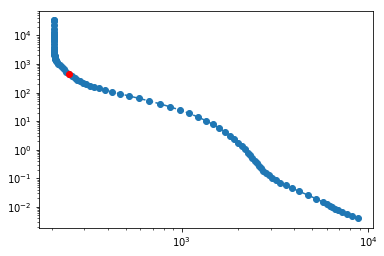

In [23]:
idx = 42
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[idx], 'ro')

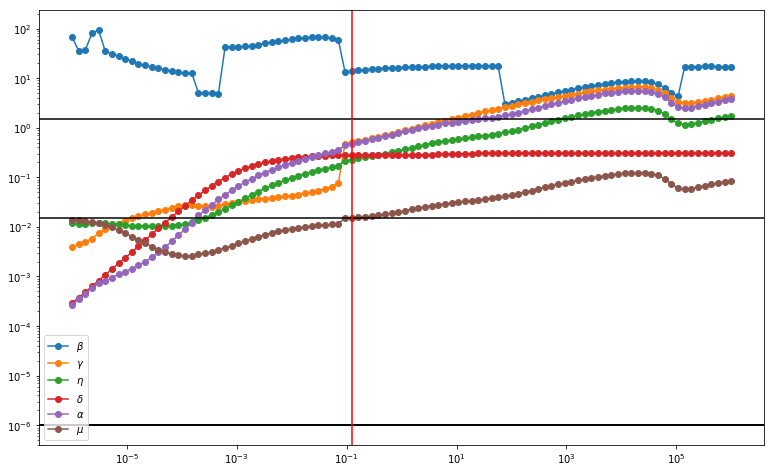

In [24]:
plt.figure(figsize=[13,8])
plt.plot(prange, [float(s['x'][-6]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-5]) for s in sols], 'o-', label=r'$\gamma$')
plt.plot(prange, [float(s['x'][-4]) for s in sols], 'o-', label=r'$\eta$')
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\delta$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\alpha$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\mu$')
for q in p0:
    plt.axhline(q, color='k')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')
plt.legend()

19.2421


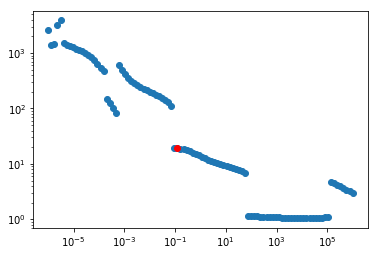

In [25]:
def r0(sol):
    b, g, e, d, a, m = getp(sol['x'])
    return b/(e+a+m)
plt.semilogx(prange, [r0(sol) for sol in sols], 'o')
plt.semilogx(prange[idx], r0(sols[idx]), 'ro')
print(r0(sols[idx]))
plt.yscale('log')

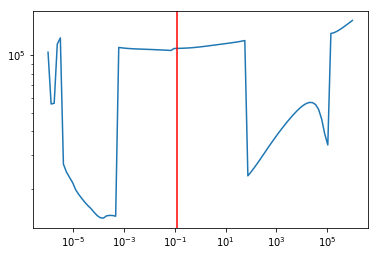

In [26]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]).sum(axis=1))
plt.loglog(prange, [getN(i) for i,_ in enumerate(prange)])
plt.axvline(prange[idx], color='r')

(DM(13.923), DM(0.507668), DM(0.228324), DM(0.279668), DM(0.479869), DM(0.0153777))


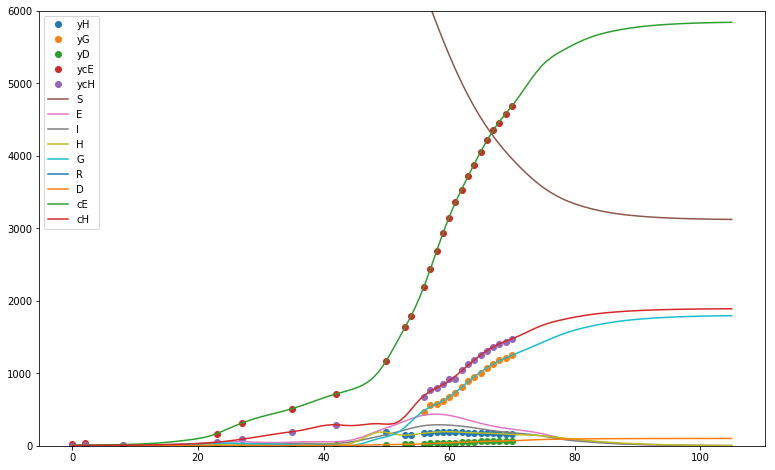

In [27]:
fig, ax=plt.subplots(figsize=[13, 8])
for data_dots in [H,G,D,cE,cH]:
    ax.plot(time, data_dots, 'o')
for data_stripe in getx(sols[idx]['x']):
    ax.plot(model.observation_times, data_stripe)
plt.legend(['yH', 'yG', 'yD', 'ycE', 'ycH', 'S', 'E', 'I', 'H', 'G', 'R', 'D', 'cE', 'cH'])
plt.ylim([1e-5, 6000])
print(getp(sols[idx]['x']))

In [28]:
print(getp(sols[idx]['x']))
[(lbl, yyy[np.argmin(np.abs(model.observation_times-65))]) for lbl, yyy in zip('seihgrdEH', getx(sols[idx]['x'])) ]

(DM(13.923), DM(0.507668), DM(0.228324), DM(0.279668), DM(0.479869), DM(0.0153777))


[('s', DM(4577)),
 ('e', DM(317.759)),
 ('i', DM(238.726)),
 ('h', DM(177.477)),
 ('g', DM(995.653)),
 ('r', DM(98612.4)),
 ('d', DM(57.6652)),
 ('E', DM(4001.45)),
 ('H', DM(1229.77))]

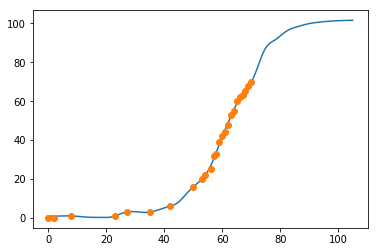

In [29]:
plt.plot(model.observation_times, getx(sols[idx]['x'])[6])
plt.plot(time, D, 'o')

(0, 6000)

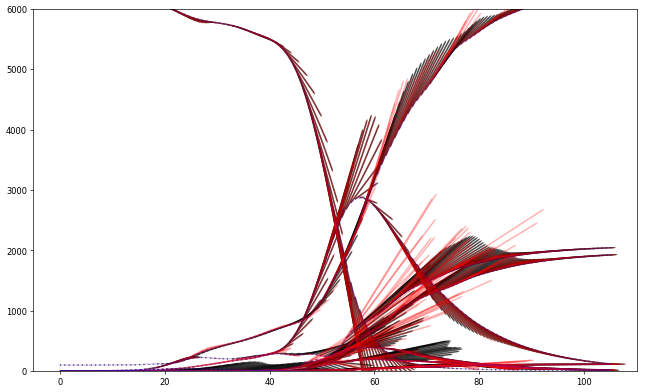

In [20]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
xx = np.vstack([xix.toarray().flatten() for xix in getx(sols[idx]['x'])])
dxxdt = np.vstack([seir(0, xxj, [float(q) for q in getp(sols[idx]['x'])]) for xxj in xx.T])
plt.plot(model.observation_times, xx.T, alpha=0.2, color='b')
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), dxxdt[:,i], 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.7)
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), np.gradient(xxi, model.observation_times), color='r', 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.3)
plt.ylim([0, 6000])

(0, 0.04)

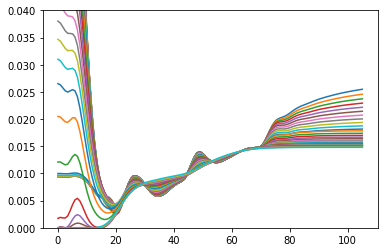

In [21]:
for i in range(30,70):
    plt.plot(model.observation_times, getx(sols[i]['x'])[6]/getx(sols[i]['x'])[-2])
plt.ylim(0, 0.04)

TypeError: You must first set_array for mappable

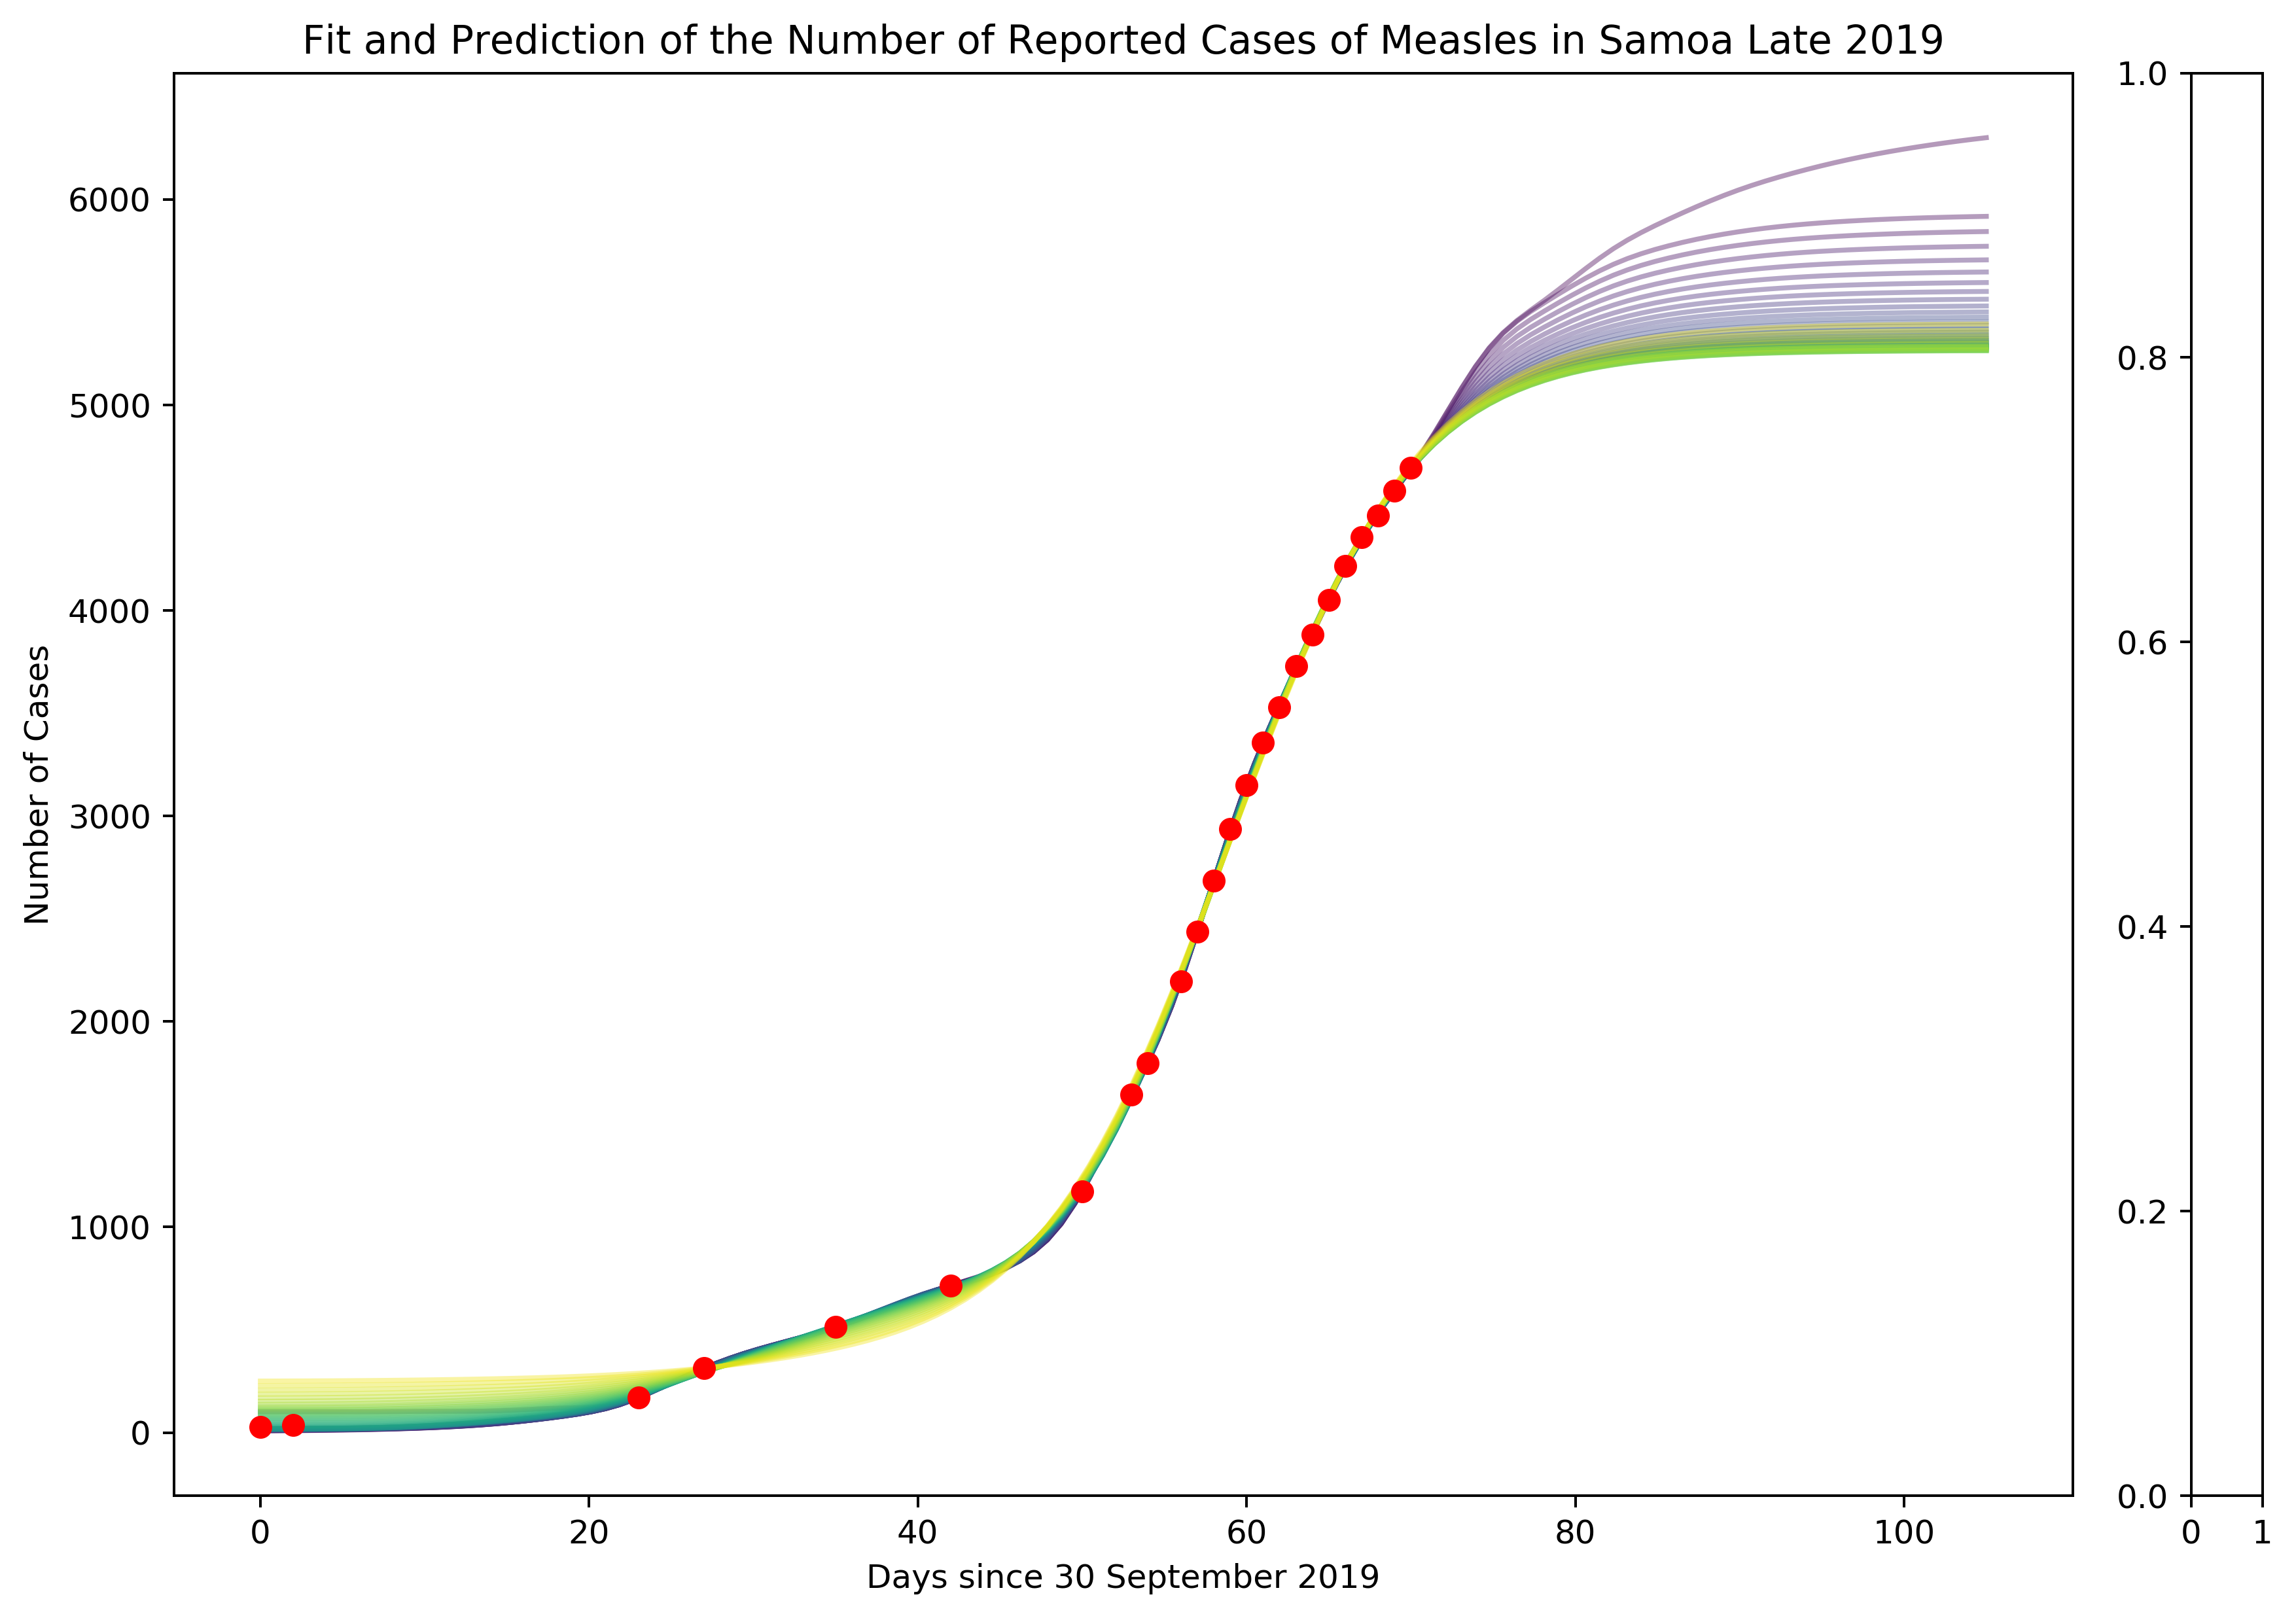

In [22]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors

plt.figure(figsize=[13,8], dpi=360)

i0, i1 = (40, -10)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


for i,p in enumerate(prange[i0:i1:]):
    plt.plot(model.observation_times, getx(sols[i+i0]['x'])[-2], color=scalarMap.to_rgba(np.log10(p)), alpha=0.4)
plt.plot(time, cE, 'ro', label="Data")
plt.title("Fit and Prediction of the Number of Reported Cases of Measles in Samoa Late 2019")
plt.xlabel("Days since 30 September 2019")
plt.ylabel("Number of Cases")
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend()

In [ ]:
plt.figure(figsize=[13,8], dpi=360)

i0, i1 = (40, -10)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


for i,p in enumerate(prange[i0:i1:]):
    plt.plot(model.observation_times, getx(sols[i+i0]['x'])[6], color='k', alpha=0.4)
plt.plot(time, D, 'ro', label="Data")
plt.title("Fit and Prediction of the Number of Deaths due to Measles in Samoa Late 2019")
plt.xlabel("Days since 30 September 2019")
plt.ylabel("Number of Deaths")
# cbar = plt.colorbar(scalarMap)
# cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend()

In [ ]:
plt.violinplot([getx(sols[i]['x'])[-2][-1] for i in range(100)])
plt.yscale('log')

In [ ]:
plt.violinplot([(getx(sols[i]['x'])[6]/getx(sols[i]['x'])[-2])[-1] for i in range(100)])
plt.ylim(0,0.04)